# FUNCIONES DE BASE - EXAMEN

Se sabe entonces que las funciones de base generan hipótesis no lineales:

$$h_{w}(x)=w^{T}\phi (x)$$

## Importando librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from linear_utils import LR

## 1. Cargando los datos de entrenamiento
Los datos de entrenamiento incluye un archivos: un archivo que presenta los datos de las temperaturas
globales en cada país de los últimos 300 años. Se cargan
el arhivo. (Los datos fueron obtenidos de: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)

In [2]:
# Saving directory
saving_dir = 'Results/'

# Create LR object
lr = LR()

# Get data
data_country = pd.read_csv('Data/GlobalLandTemperaturesByCountry.csv')
data_country.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


Sólo los datos de México se analizarán

In [3]:
# Boolean vector to filter only temperatures from mexico
is_mexico = data_country['Country'] == 'Mexico'
data_mexico = data_country[is_mexico]
data_mexico.head()

# Get vector containing all years of temperatures of Mexico
years_mexico_1 = np.unique(data_mexico['dt'].apply(lambda x: x[:4]))[2:]
years_mexico_2 = np.unique(data_mexico['dt'].apply(lambda x: x[6:]))[2:-7]
years_mexico_2 = np.delete(years_mexico_2, 100, axis=0)
years_mexico = np.concatenate((years_mexico_1, years_mexico_2), axis=0)

# Get only average temperatures
temp_mexico = data_mexico['AverageTemperature']
avg_temps_mexico = {}

# Pre-process all years to have the same format and get annual temperature averages
print('Getting training data...')
for year in years_mexico:

    # Get years with '-' separator
    is_year = data_country['dt'].apply(lambda x: x.split('-')[0]) == year
    avg = np.array(temp_mexico[is_year]).mean()

    if not np.isnan(avg):
        avg_temps_mexico[year] = avg
    else:
        # Get years with '/' separator
        is_year = data_country['dt'].apply(lambda x: x.split('/')[-1]) == year
        avg = np.array(temp_mexico[is_year]).mean()

        if not np.isnan(avg):
            avg_temps_mexico[year] = avg

# Get only average values of temperature
y_mexico = np.array([list(avg_temps_mexico.values())]).T

# Assign time values as training data
x_mexico = np.array(list(avg_temps_mexico.keys()))
x_mexico = [float(x) for x in x_mexico]
x_mexico = np.array([x_mexico]).T

Getting training data...


C:\Users\jonat\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice.
C:\Users\jonat\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Se grafican los datos

Text(0, 0.5, 'Temperatura Promedio')

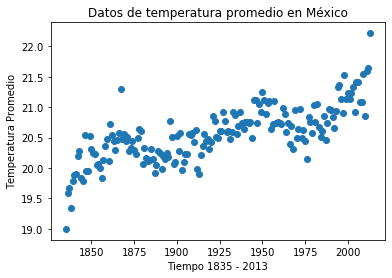

In [4]:
# Graficamos los datos
plt.figure(1)
plt.scatter(x_mexico, y_mexico)
plt.title('Datos de temperatura promedio en México')
plt.xlabel('Tiempo 1835 - 2013')
plt.ylabel('Temperatura Promedio')

Creando sets de entrenamiento y validación

In [5]:
# Make the classic training - test split
split = 0.7
x_train = x_mexico[0:round(split * x_mexico.shape[0])]
y_train = y_mexico[0:round(split * y_mexico.shape[0])]
x_test = x_mexico[round(split * x_mexico.shape[0]):]
y_test = y_mexico[round(split * y_mexico.shape[0]):]

# Data normalization
x_norm = lr.norm(x_mexico)
y_norm = lr.norm(y_mexico)

# Splitting normalized data
x_norm_train = x_norm[0:round(split * x_norm.shape[0])]
y_norm_train = y_norm[0:round(split * y_norm.shape[0])]
x_norm_test = x_norm[round(split * x_norm.shape[0]):]
y_norm_test = y_norm[round(split * y_norm.shape[0]):]

## 2. Funciones polinomiales - Ecuaciones Normales

In [6]:
# Create list of degrees
num_degrees = 10
range_degrees = range(1, num_degrees + 1)
list_degrees = []
list_lambdas = []
list_costs_train = []
list_costs_test = []
weights = []

# Run algorithm for a certain number of regularization constants
num_lambdas = 5
lambdas = np.linspace(0, 0.2, num_lambdas, dtype='float64')

# Iterate for each curve degree polynomial
for i, degree in enumerate(range_degrees):

    degrees = range(degree + 1)

    # Iterate for every regularization constant
    for l2 in lambdas:
        # Creating design matrix
        phi_train = lr.expand(x_train, bf=lr.polynomial_basis_function, bf_args=degrees[1:])
        phi_test = lr.expand(x_test, bf=lr.polynomial_basis_function, bf_args=degrees[1:])

        # Normal equations optimization
        w_NE = lr.fit_ne(phi_train, y_train, l2=l2)
        weights.append(w_NE)

        # Predicting with best weights
        predictions_ne_train = phi_train.dot(w_NE)
        predictions_ne_test = phi_test.dot(w_NE)

        # Final cost computation
        j_NE_train = lr.cost(w_NE, phi_train.T, y_train, l2=l2)
        j_NE_test = lr.cost(w_NE, phi_test.T, y_test, l2=l2)

        # Save costs and other important variables
        list_costs_train.append(j_NE_train)
        list_costs_test.append(j_NE_test)
        list_lambdas.append(l2)
        list_degrees.append(degree)

        # Graphing results
        plt.figure()
        plt.scatter(x_mexico, y_mexico)
        plt.plot(x_train, predictions_ne_train, 'r',
                 linewidth=5,
                 label='Training Cost {0:0.03f}'.format(j_NE_train))
        plt.plot(x_test, predictions_ne_test, 'g',
                 linewidth=5,
                 label='Validation Cost {0:0.03f}'.format(j_NE_test))
        plt.title('Polynomial degree {0} - L2 {1:0.03f}'.format(degree, l2))
        plt.xlabel('Time 1752 - 2015')
        plt.ylabel('Annual Average Temperature')
        plt.legend(loc='lower right')
        plt.savefig(saving_dir + 'poly_ne/degree {0} lambda {1:0.02f}.png'.format(degree, l2))
        plt.close()

# Getting future times
x_future = np.array([np.arange(2015, 2100)], dtype='float64').T
val, idx = min((val, idx) for (idx, val) in enumerate(list_costs_test))

# Get the best model
best_w_NE = weights[idx]
best_degree = list_degrees[idx]
best_lambda = list_lambdas[idx]
degrees = range(best_degree + 1)

# Create design matrix
phi_future = lr.expand(x_future, bf=lr.polynomial_basis_function, bf_args=degrees[1:])

# Predict future
predictions_future_ne = phi_future.dot(best_w_NE)

# Graph results
plt.figure()
plt.title('Future predictions - Degree {0} - Lambda {1:0.03f}'.format(best_degree, best_lambda))
plt.xlabel('Time 1752 - 2100')
plt.ylabel('Annual Average Temperature')
plt.legend(loc='lower right')
plt.scatter(x_mexico, y_mexico)
plt.plot(x_future, predictions_future_ne, 'r',
         linewidth=5,
         label='Validation Cost: {0:0.03f}'.format(list_costs_test[idx]))
plt.legend(loc='lower right')
plt.savefig(saving_dir + 'poly_ne/future.png')
plt.close()

No handles with labels found to put in legend.


## 3. Funciones polinomiales - Descenso por gradiente

In [7]:
# Create list of degrees
num_degrees = 7
range_degrees = range(1, num_degrees + 1)
list_degrees = []
list_lambdas = []
list_costs_train = []
list_costs_test = []
weights = []

# Run algorithm for a certain number of regularization constants
num_lambdas = 5
lambdas = np.linspace(0, 0.2, num_lambdas, dtype='float64')

# Optimizing weights with LMS
alpha = 0.1
num_iter = 1000

for i, degree in enumerate(range_degrees):

    degrees = range(degree + 1)

    for l2 in lambdas:
        # Design matrix
        phi_train = lr.expand(x_norm_train, bf=lr.polynomial_basis_function, bf_args=degrees[1:])
        phi_test = lr.expand(x_norm_test, bf=lr.polynomial_basis_function, bf_args=degrees[1:])

        # Optimization
        w_LMS, j_LMS_train, j_LMS_test = lr.fit_gd(phi_train.T, y_norm_train, phi_test.T, y_norm_test, num_iter, alpha,
                                                   l2=l2)
        weights.append(w_LMS)

        # Training predictions
        predictions_LMS_norm_train = lr.h(w_LMS, phi_train.T)
        predictions_LMS_train = lr.denormalize(predictions_LMS_norm_train, min(y_mexico), max(y_mexico))

        # Validation predictions
        predictions_LMS_norm_test = lr.h(w_LMS, phi_test.T)
        predictions_LMS_test = lr.denormalize(predictions_LMS_norm_test, min(y_mexico), max(y_mexico))

        # Final predictions
        list_costs_train.append(j_LMS_train[-1])
        list_costs_test.append(j_LMS_test[-1])
        list_lambdas.append(l2)
        list_degrees.append(degree)

        # Graphing results
        fig, axs = plt.subplots(2, 1)
        fig.subplots_adjust(hspace=0.5, wspace=0.5)

        axs[0].scatter(x_mexico, y_mexico)
        axs[0].plot(x_train, predictions_LMS_train.T, 'r',
                    linewidth=5,
                    label='Training Cost {0:0.3f}'.format(j_LMS_train[-1]))
        axs[0].plot(x_test, predictions_LMS_test.T, 'g',
                    linewidth=5,
                    label="Validation Cost {0:0.3f}".format(j_LMS_test[-1]))
        axs[0].set_title('Polynomial degree {0} - L2 {1}'.format(degree, l2))
        axs[0].set_xlabel('Time 1752 - 2015')
        axs[0].set_ylabel('Annual Average Temperature')
        axs[0].legend(loc='lower right')

        # Graphing costs
        it = np.linspace(0, num_iter, num_iter)
        axs[1].set_title('Cost Polynomial Degree {0}'.format(degree))
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Cost')
        axs[1].plot(it, j_LMS_train, color='r', label='Training Cost {0:0.3f}'.format(float(j_LMS_train[-1])))
        axs[1].plot(it, j_LMS_test, color='g', label='Validation Cost {0:0.3f}'.format(float(j_LMS_test[-1])))
        axs[1].legend(loc='lower right')

        plt.savefig(saving_dir + 'poly_gd/degree {0} lambda {1:0.02f}.png'.format(degree, l2))
        plt.close()

# Setting future predictions
x_future_norm = np.array([np.linspace(1, 1.5, 50)], dtype='float64').T
x_future = lr.denormalize(x_future_norm, min(x_mexico), max(x_mexico))

val, idx = min((val, idx) for (idx, val) in enumerate(list_costs_test))
best_w_LMS = weights[idx]
best_degree = list_degrees[idx]
degrees = range(best_degree + 1)

phi_future = lr.expand(x_future_norm, bf=lr.polynomial_basis_function, bf_args=degrees[1:])
predictions_LMS_future = lr.h(best_w_LMS, phi_future.T)

# Denormalize
predictions_LMS_future = lr.denormalize(predictions_LMS_future, min(y_mexico), max(y_mexico))

plt.figure()
plt.title('Future predictions - Degree {0} - Lambda {1:0.03f}'.format(best_degree, best_lambda))
plt.xlabel('Time 1752 - 2100')
plt.ylabel('Annual Average Temperature')
plt.scatter(x_mexico, y_mexico)
plt.plot(x_future, predictions_LMS_future.T, 'r', linewidth=5,
         label='Validation Cost {0:0.3f}'.format(list_costs_test[idx]))
plt.legend(loc='lower right')
plt.savefig(saving_dir + 'poly_gd/future.png')
plt.close()

## 4. Funciones gaussianas - Descenso por gradiente

In [8]:
# Create list with different numbers of Gaussian curves
num_gaussian = range(5, 10)
std_dev = np.linspace(0.01, 1, 5)
list_costs_train = []
list_costs_test = []
weights = []
list_lambdas = []
list_gaussian = []
list_deviations = []

# Run algorithm for a certain number of regularization constants
num_lambdas = 5
lambdas = np.linspace(0, 0.2, num_lambdas, dtype='float64')

# Set parameters for gradient descent
alpha = 0.01
num_iter = 5000

# Arguments for creating design matrix
bf_args = []
min_loss = 1000000000000000
counter = 0

for i in num_gaussian:
    for j in std_dev:
        for l2 in lambdas:

            # Creating arguments for Design Matrix
            deviations = np.full((i, 1), j)
            mus = np.array([np.linspace(0, 1, i)]).T
            bf_args = np.append(mus, deviations, axis=1)

            # Design matrix with "n" Gaussian curves wih variance = "x"
            phi_train_g = lr.expand(x_norm_train, bf=lr.gaussian_basis_function, bf_args=bf_args)
            phi_test_g = lr.expand(x_norm_test, bf=lr.gaussian_basis_function, bf_args=bf_args)

            # Optimize
            w_LMS, j_LMS_train, j_LMS_test = lr.fit_gd(phi_train_g.T, y_norm_train, phi_test_g.T, y_norm_test,
                                                       num_iter, alpha, l2=l2)

            # Save weights and parameters
            weights.append(w_LMS)
            list_lambdas.append(l2)
            list_gaussian.append(i)
            list_deviations.append(j)

            # Calculate predictions
            predictions_LMS_train = phi_train_g.dot(w_LMS)
            predictions_LMS_test = phi_test_g.dot(w_LMS)

            # Calculate final cost
            list_costs_train.append(j_LMS_train[-1])
            list_costs_test.append(j_LMS_test[-1])

            # Denormalize
            predictions_train = lr.denormalize(predictions_LMS_train, min(y_mexico), max(y_mexico))
            predictions_test = lr.denormalize(predictions_LMS_test, min(y_mexico), max(y_mexico))

            # Graphing results
            fig, axs = plt.subplots(2, 1)
            fig.subplots_adjust(hspace=0.5, wspace=0.5)

            axs[0].scatter(x_mexico, y_mexico)
            axs[0].plot(x_train, predictions_train, 'r', linewidth=5,
                        label='Training Cost {0:0.3f}'.format(j_LMS_train[-1]))
            axs[0].plot(x_test, predictions_test, 'g', linewidth=5,
                        label='Validation Cost {0:0.3f}'.format(j_LMS_test[-1]))

            axs[0].set_title('Number of Gaussian {0} - Deviation {0:0.03f} - L2 {2:0.03f}'.format(i, j, l2))
            axs[0].set_xlabel('Time 1752 - 2015')
            axs[0].set_ylabel('Annual Average Temperature')
            axs[0].legend(loc='lower right')

            # Graphing cost
            it = np.linspace(0, num_iter, num_iter)
            axs[1].set_title('Number of Gaussian {0} - Deviation {0:0.03f} - L2 {2:0.03f}'.format(i, j, l2))
            axs[1].set_xlabel('Epochs')
            axs[1].set_ylabel('Cost')
            axs[1].plot(it, j_LMS_train, color='r', label='Training cost {0:0.3f}'.format(j_LMS_train[-1]))
            axs[1].plot(it, j_LMS_test, color='g', label='Validation cost{0:0.3f}'.format(j_LMS_test[-1]))
            axs[1].legend(loc='lower right')

            plt.savefig(saving_dir + 'gauss_gd/gauss {0} deviation {1:0.03f} l2 {2:0.03f}.png'.format(i, j, l2))
            plt.close()

            counter += 1

# Predicting the future
x_future_norm = np.array([np.linspace(1, 1.3, 20)]).T
x_future = lr.denormalize(x_future_norm, min(x_mexico), max(x_mexico))

# Get best weights
val, idx = min((val, idx) for (idx, val) in enumerate(list_costs_test))
best_w_LMS = weights[idx]
best_lambda = list_lambdas[idx]
best_deviation = list_deviations[idx]
best_gaussian = list_gaussian[idx]

# Creating arguments
deviations = np.full((best_gaussian, 1), best_deviation)
mus = np.array([np.linspace(0, 1, best_gaussian)]).T
bf_args = np.append(mus, deviations, axis=1)
phi_future = lr.expand(x_future_norm, bf=lr.gaussian_basis_function, bf_args=bf_args)

# Predict future
predictions_LMS_future = phi_future.dot(best_w_LMS)

# Denormalize
predictions_future = lr.denormalize(predictions_LMS_future, min(y_mexico), max(y_mexico))

plt.figure()
plt.title('Future predictions - Gaussian {0} - Deviation {1:0.03f} - L2 {2:0.03f}'.format(best_gaussian, best_deviation, best_lambda))
plt.xlabel('Time 1752 - 2100')
plt.ylabel('Annual Average Temperature')
plt.scatter(x_mexico, y_mexico)
plt.plot(x_future, predictions_future, 'r', linewidth=5,
         label='Validation Cost {0:0.3f}'.format(list_costs_test[idx]))
plt.legend(loc='lower right')
plt.savefig(saving_dir + 'gauss_gd/future.png')
plt.close()